# Gemicai tutorial 4: ClassifierTree
In this tutorial we'll give a demonstration of the Gemicai.ClassifierTree and its core functionality

In [1]:
import gemicai as gem
import torch
import torchvision.models as models
from matplotlib import pyplot as plt
from pprint import pprint

## 4.1 Creating the tree
To create a ClassifierTree, first select a base_dataset, from this dataset the classes of the tree will be determined.

In [2]:
# Select base gemset for initialisation of classes
gemset_path = '/mnt/SharedStor/gemset/DX/'

# Specify the labels the tree should classify. Make sure you specify them in the right order!
relevant_labels = ['Modality', 'BodyPartExamined', 'StudyDescription']

# If you already know what classes you want to classify, specify them as constraints.
# This is optional! If no constraints specified, the classes will be automatically configured.
# For demonstration purposes, we will only look at DX images concerning HAND and FOOT
constraints = {
    'Modality': 'DX',
    'BodyPartExamined': ['HAND', 'FOOT']
}

base_dataset = gem.DicomoDataset.get_dicomo_dataset(gemset_path, relevant_labels, constraints=constraints)


The root of the tree will only have 1 class, DX. That means it will also only have 1 child named DX. The DX node will have 2 children, HAND and FOOT. The StudyDescription children will be initialized according to what classes exist in base_dataset. For more information on datasets and how to construct them refer to tutorial 3.

In [3]:
# Check how many images are in the dataset
base_dataset.summarize('BodyPartExamined')

| Class (BodyPartExamined)   |   Frequency |
|----------------------------+-------------|
| FOOT                       |        1146 |
| HAND                       |         407 |

Total number of training images: 1553 
Total number of classes: 2



To initialize the tree, we need the following parameters

In [4]:
# Make a default Classifier to initialize all nodes in the tree. 
# All specified attributres of the classifier will be the default for all nodes in the tree.
module = models.resnet18(pretrained=False)
loss_function = torch.nn.CrossEntropyLoss()

# Classes can be set to [], as only the hyper parameters of the Classifier matter
default_classifier = gem.Classifier(module, classes=[], loss_function=loss_function, enable_cuda=True)

# Create a directory where you want to save the tree
dx_tree_path = '/mnt/SharedStor/tutorials/tutorial4/example_tree/'

# Calling this function will start initializing the tree
#tree = gem.ClassifierTree(default_classifier, relevant_labels, base_dataset, dx_tree_path)
tree = gem.ClassifierTree.from_dir(dx_tree_path)

# Print information about the tree when it's done
print(tree)

|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | Modality         |             1 |            1   |
|       1 | BodyPartExamined |             1 |            2   |
|       2 | StudyDescription |             2 |           14.5 |



## 4.2 Training the tree
To train the whole tree at once, simply use the train function. Refer to tutorial 3 if you want to learn more about how to create a training and test dataset.

In [5]:
trainset_path = '/mnt/SharedStor/gemset/DX/train'
testset_path = '/mnt/SharedStor/gemset/DX/test'

trainset = gem.DicomoDataset.get_dicomo_dataset(trainset_path, relevant_labels, constraints=constraints)
testset = gem.DicomoDataset.get_dicomo_dataset(testset_path, relevant_labels, constraints=constraints)

In [6]:
tree.train(trainset, epochs=1)

Training of ClassifierTree /mnt/SharedStor/tutorials/tutorial4/example_tree/ begun. Total nodes to train: 4
|  Node | Depth | Parents              |  Classes | Train size |  Train acc | Elapsed  | 
|-------+-------+----------------------+----------+------------+------------+----------|
|     1 |     0 | .                    |        1 |       1263 |     100.0% | 00:00:26 | 
|     2 |     1 | DX                   |        2 |       1263 |     92.56% | 00:00:26 | 
|     3 |     2 | DX/FOOT              |       12 |        760 |     83.29% | 00:00:23 | 
|     4 |     2 | DX/HAND              |       17 |        340 |     62.35% | 00:00:19 | 


## 4.3 Evaluating the tree
Training a ClassifierTree like this is a good start, but to get the most out of your tree the indidual nodes will need tweaking. To inspect the trees' performance call evaluate.

In [7]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     1 | .                    |        1 |        290 |     100.0% | 
|     2 |     1 | DX                   |        2 |        290 |     92.41% | 
|     3 |     2 | DX/FOOT              |       12 |        192 |     81.25% | 
|     4 |     2 | DX/HAND              |       17 |         67 |     58.21% | 


## 4.4 Saving and retrieving the tree

A ClassifierTree consits of ClassifierNodes, when intialising the tree, its nodes are automatically saved. You can retrieve a tree by specifying its directory.

In [8]:
tree = None
tree = gem.ClassifierTree.from_dir(dx_tree_path)
print(tree)

|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | Modality         |             1 |            1   |
|       1 | BodyPartExamined |             1 |            2   |
|       2 | StudyDescription |             2 |           14.5 |



Every sub tree within a ClassifierTree is also a ClassifierTree, and therefore can be loaded as a its own tree.

In [9]:
# Print file path of all nodes in the tree
for node in tree.nodes_in_tree():
    print(node)
    
print('\n')

# This is the subtree from the child DX
subtree = gem.ClassifierTree.from_dir(tree.root.children()[0])
print(subtree)

/mnt/SharedStor/tutorials/tutorial4/example_tree/Modality.gemnode
/mnt/SharedStor/tutorials/tutorial4/example_tree/DX/BodyPartExamined.gemnode
/mnt/SharedStor/tutorials/tutorial4/example_tree/DX/FOOT/StudyDescription.gemnode
/mnt/SharedStor/tutorials/tutorial4/example_tree/DX/HAND/StudyDescription.gemnode


|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | BodyPartExamined |             1 |            2   |
|       1 | StudyDescription |             2 |           14.5 |



## 4.5 Classifying with the tree
Now that we've created and trained the tree, we are ready to classify images. The classify function will return a list for every label. In this list you can find its best 3 guesses with a certaintiy score, the best score is always in the first position, therefore the predicted label = list[0][0]

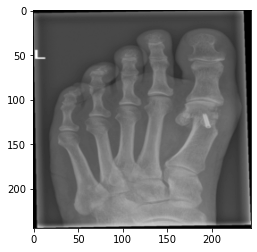

True labels for image 1:
['DX', 'FOOT', 'Voet links']

Prediction for image 1:
{'BodyPartExamined': [('FOOT', 0.9825648665428162),
                      ('HAND', 0.017435196787118912)],
 'Modality': [('DX', 1.0)],
 'StudyDescription': [('Voet links', 0.8263227343559265),
                      ('Voet rechts', 0.07788056135177612),
                      ('Teen rechts', 0.023841599002480507)]}


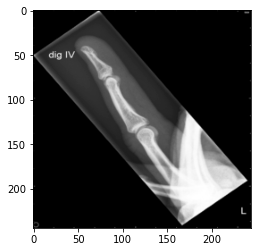

True labels for image 2:
['DX', 'HAND', 'Vinger links']

Prediction for image 2:
{'BodyPartExamined': [('HAND', 0.8461107015609741),
                      ('FOOT', 0.15388932824134827)],
 'Modality': [('DX', 1.0)],
 'StudyDescription': [('Vinger rechts', 0.587194561958313),
                      ('Os scaphoid rechts', 0.069459930062294),
                      ('Vinger links', 0.06342021375894547)]}


In [10]:
# Retrieving 2 image tensors from the testset for demonstration purposes. 
for data in testset:
    # Get an image where BodyPartExamined == FOOT
    if data[2] == 'FOOT':
        image1 = data[0]
        labels1 = data[1:]
    # Get an image where StudyDescription == Vinger links
    if data[3] == 'Vinger links':
        image2 = data[0]
        labels2 = data[1:]

# Simple function for plotting the image
def plot_image(tensor, cmap='gray'):
    plt.imshow(tensor[0], cmap=cmap)
    plt.show()
    
plot_image(image1)
print('True labels for image 1:')
pprint(labels1)
print('\nPrediction for image 1:')
pprint(tree.classify(image1))

plot_image(image2, cmap='gray_r')
print('True labels for image 2:')
pprint(labels2)
print('\nPrediction for image 2:')
pprint(tree.classify(image2))


As you can see the tree managed to correctly classify all labels for the first image. However, it got the StudyDescription of the second image incorrect. It classified it as "Vinger rechts", but should have been "Vinger links" (Dutch for "Right finger" and "Left finger", respectively). Easy to see for us humans, because of the L in the bottom right corner, but difficult for an AI that looks at the whole image.